
# eBay Auctions (May–June 2004): KNN Classifier

**Objective**: Predict whether an auction will be **competitive** (i.e., it receives at least two bids) using item, seller, and auction-setting features.


## Dataset & Variables

**File**: `ebayAuctions.xlsx` → **Sheet**: `eBay auctions`  
**Rows**: `1972` &nbsp;&nbsp; **Columns**: `8`

**Columns** (original):
- `Category` *(categorical)*: auction category (18 levels).
- `Currency` *(categorical)*: listing currency (`US`, `EUR`, `GBP`).
- `sellerRating` *(numeric)*: seller's eBay rating (non-negative integer, heavy-tailed).
- `Duration` *(numeric / discrete)*: length of auction in days (e.g., 1, 3, 5, 7, 10).
- `endDay` *(categorical)*: day of week the auction ends.
- `ClosePrice` *(numeric)*: final price at close (observed **after** auction).
- `OpenPrice` *(numeric)*: opening price set by seller.
- `Competitive?` *(binary 0/1)* → renamed to `Competitive`.

**Target**: `Competitive` (1 = competitive, 0 = non-competitive).


## Setup

In [1]:
DATA_PATH = "../Data/ebayAuctions.xlsx"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree, export_text
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
sns.set_theme(context="notebook", style="whitegrid")

RANDOM_STATE = 42

## Load data & initial checks

In [2]:
df = pd.read_excel(DATA_PATH, sheet_name="eBay auctions").rename(columns={"Competitive?":"Competitive"})

# Quick overview
display(df.head())
print("\nShape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

# Basic sanity checks
print("\nMissing values:")
print(df.isna().sum())

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0



Shape: (1972, 8)

Dtypes:
Category         object
Currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive       int64
dtype: object

Missing values:
Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive     0
dtype: int64



## Task 1 — Data Preparation

This section only contains the code for preparing the data, which includes:
 - Change the currency unit for `ClosePrice` and `OpenPrice` into USD;
 - Perform log transformation on `sellerRating`, `ClosePrice`, and `OpenPrice`;
 - Create dummy variables for each levels in the categorical variables.
 
Note that at the end of data preprocessing step, the original columns `Currency`, `sellerRating`, `ClosePrice`, and `OpenPrice` are removed because the information stored in those columns are represented by the new transformed columns. We will then perform standardization on numeric columns in the following section when fitting the KNN model.

### 1. Transformations (log1p) for skewness & stability

In [3]:
exchange_rates = {"US": 1.0, "EUR": 1.17, "GBP": 1.34}
df["ClosePrice"] = df.apply(lambda row: row["ClosePrice"] * exchange_rates[row["Currency"]], axis=1)
df["OpenPrice"] = df.apply(lambda row: row["OpenPrice"] * exchange_rates[row["Currency"]], axis=1)

# Create transformed versions; keep original for interpretability.
df["log_OpenPrice"] = np.log1p(df["OpenPrice"])
df["log_ClosePrice"] = np.log1p(df["ClosePrice"])
df["log_sellerRating"] = np.log1p(df["sellerRating"])

display(df[["OpenPrice","log_OpenPrice","ClosePrice","log_ClosePrice","sellerRating","log_sellerRating"]].describe())

,OpenPrice,log_OpenPrice,ClosePrice,log_ClosePrice,sellerRating,log_sellerRating
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,13.323836,1.845711,38.428039,2.682757,3560.238337,7.142451
std,39.101528,1.122315,93.707890,1.268424,5973.011033,1.718672
min,0.010000,0.009950,0.010000,0.009950,0.000000,0.000000
25%,1.439100,0.891629,4.990000,1.790091,595.000000,6.390241
50%,4.950000,1.783391,10.787400,2.467031,1853.000000,7.525101
75%,10.990000,2.484073,29.950000,3.432373,3380.000000,8.125927
max,999.000000,6.907755,1010.037600,6.918732,37727.000000,10.538158


In [4]:
df.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive,log_OpenPrice,log_ClosePrice,log_sellerRating
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.00995,0.00995,8.08641
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.00995,0.00995,8.08641
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.00995,0.00995,8.08641
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.00995,0.00995,8.08641
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0,0.00995,0.00995,8.08641


### 2. Dummy variables for modeling

In [5]:
# We'll keep Duration as categorical (discrete day counts) for interpretability in trees & KNN.
cat_cols = ["Category", "endDay", "Duration"]
num_cols = ["log_sellerRating", "log_OpenPrice", "log_ClosePrice"]

df_model = df.copy()
X_full = pd.get_dummies(df_model[cat_cols + num_cols], drop_first=True)
y = df_model["Competitive"].astype(int)

print("X_full shape:", X_full.shape)
X_full.head()

X_full shape: (1972, 27)


,Duration,log_sellerRating,log_OpenPrice,log_ClosePrice,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,Category_Collectibles,Category_Computer,Category_Electronics,Category_EverythingElse,Category_Health/Beauty,Category_Home/Garden,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,5,8.08641,0.00995,0.00995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
1,5,8.08641,0.00995,0.00995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
2,5,8.08641,0.00995,0.00995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3,5,8.08641,0.00995,0.00995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
4,5,8.08641,0.00995,0.00995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False



## Task 2 — KNN Classifier

### 1. Data Split into Training and Test Data 

We split the data into training and test sets with a 60%/40% split as suggested in the instruction. The predictors and response variable in our data are:  
 - **Response:** `Competitive?`
 - **Categorical predictors:** `Category`, `Duration`, and `endDay`
 - **Numeric predictors:** `selletRating`, `OpenPriceUSD`, and `ClosePriceUSD`

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)

In [7]:
X_train.shape

(1183, 27)

In [8]:
X_train.head()

,Duration,log_sellerRating,log_OpenPrice,log_ClosePrice,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,Category_Collectibles,Category_Computer,Category_Electronics,Category_EverythingElse,Category_Health/Beauty,Category_Home/Garden,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
1833,7,8.387312,3.749269,3.749269,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1196,10,2.944439,2.103585,3.117352,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1071,7,5.327876,2.404573,2.404573,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
1000,7,6.532334,2.014903,2.014903,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1776,5,7.218910,3.464172,3.464172,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [9]:
y_train

1833    0
1196    0
1071    0
1000    0
1776    0
       ..
1288    0
597     0
1919    1
1438    1
1267    1
Name: Competitive, Length: 1183, dtype: int64

### 2. Apply Standardization on Numeric Predictors

Since we are fitting a KNN model, which is very sensitive to the scales of numeric data, we also have to apply the standardization on numeric predictors. To perform the transformations on numeric columns, we will use a `ColumnTransformer`. Then we will wrap the transformation in a `pipeline` so that we are only fitting the transformer on training data and applying the transformation on training and test data so that we can avoid data leakage problems.

In [10]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="passthrough"
)
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

### 3. K-Fold Cross Validation

Now we can use k-fold Cross Validation to find the best value of k for our KNN model. Since this is a classification problem, we are using `accuracy` as the scoring method when comparing the performance of KNN models with different values of k. The `accuracy` measures the fraction of correct predictions by our model.

In [11]:
# Defining the parameters in k-fold CV
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)
k_values = np.arange(1, 20)
param_grid = {"knn__n_neighbors": k_values}

In [12]:
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

In [13]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.787003 using {'knn__n_neighbors': np.int64(1)}


Text(0, 0.5, 'Accuracy')

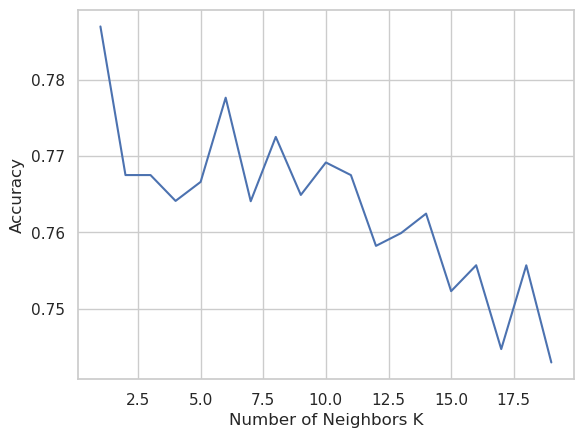

In [14]:
means = grid_result.cv_results_["mean_test_score"]
plt.plot(k_values, means)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")

In [15]:
means[0:6]

array([0.78700328, 0.76751175, 0.76751175, 0.76412192, 0.76661444,
       0.77765988])

### 4. Fitting the KNN Classifier with the Best K Value

From the cross validation above, we have found that the best value of k when fitting the KNN classifier on our data is at `k = 1`. However, with `k = 1`, we doubt that such a model will be more likely to overfit on the training data. From the validation accuracy score plot, we can see that a KNN classifier with `k = 6` also gives us a reasonably good validation accuracy. Therefore, in this section we will fit a KNN classifier with `k = 1` and `k = 6` separately and compare their predictions on the test data.

In [16]:
pipe_k1 = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier(n_neighbors=1))
])
pipe_k1.fit(X_train, y_train)
estimates_k1 = pipe_k1.predict(X_test)

pipe_k6 = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier(n_neighbors=6))
])
pipe_k6.fit(X_train, y_train)
estimates_k6 = pipe_k6.predict(X_test)

In [17]:
acc1 = accuracy_score(y_test, estimates_k1)
print("Accuracy:", acc1)
acc6 = accuracy_score(y_test, estimates_k6)
print("Accuracy:", acc6)

Accuracy: 0.770595690747782
Accuracy: 0.7604562737642585


In [18]:
# Compare the performance of two KNN models in a table
results = {
    'k-value': [1, 6],
    'cross_validation_accuracy': [means[0], means[5]],
    'test_accuracy': [acc1, acc6]
}

results_table = pd.DataFrame(results)
results_table = results_table.round(4)
results_table

,k-value,cross_validation_accuracy,test_accuracy
0,1,0.7870,0.7706
1,6,0.7777,0.7605


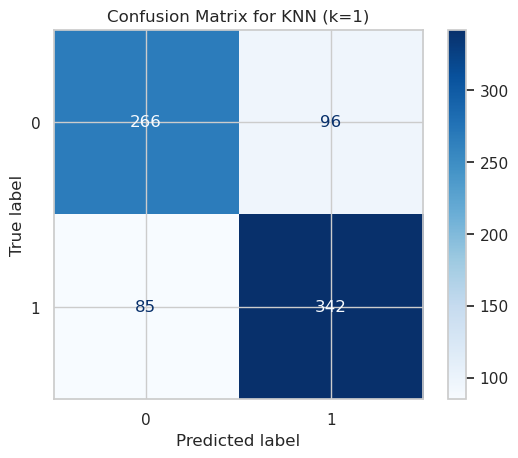

In [19]:
cm1 = confusion_matrix(y_test, estimates_k1)
cm1_display = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=pipe_k1.classes_)
cm1_display.plot(cmap="Blues")
plt.title("Confusion Matrix for KNN (k=1)")
plt.show()

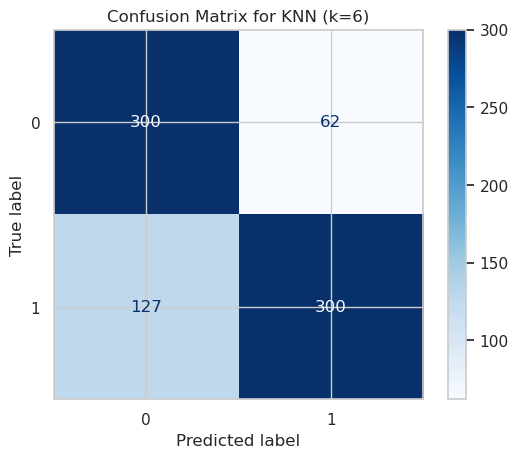

In [20]:
cm6 = confusion_matrix(y_test, estimates_k6)
cm6_display = ConfusionMatrixDisplay(confusion_matrix=cm6, display_labels=pipe_k6.classes_)
cm6_display.plot(cmap="Blues")
plt.title("Confusion Matrix for KNN (k=6)")
plt.show()